# Signing-in

Note that you will need to sign-in to use this notebook. Simply click on the `[➡` icon on the extreme right of the title bar.

## Imports

In [1]:
import struct
from gzip import GzipFile
from StringIO import StringIO
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random

## Parsing MNIST format

The files are gzipped and in the format described at http://yann.lecun.com/exdb/mnist/

In [2]:
def read_labels(label_data_raw):
  file = GzipFile(mode = 'r', fileobj = StringIO(label_data_raw))
  (magic_number, num_items) = struct.unpack('>II', file.read(8))
  assert magic_number == 2049, 'Not a label file!'
  return struct.unpack('>' + 'B' * num_items, file.read(num_items))

def read_images(image_data_raw):
  file = GzipFile(mode = 'r', fileobj = StringIO(image_data_raw))
  (magic_number, num_items, rows, cols) = struct.unpack('>IIII', file.read(16))
  assert magic_number == 2051, 'Not an image file!'
  assert rows == 28 and cols == 28, 'Not 28 x 28 images.'
  num_pixels = rows * cols
  images = []
  for i in range(num_items):
    images.append(map(lambda x: x / 255.0,
                      struct.unpack('>' + 'B' * num_pixels, file.read(num_pixels))))
  return images

def to_one_hot(value):
  result = [0.0] * 10
  result[value] = 1.0
  return result

## Displaying images

In [3]:
def plot_image(image):
#   image = [image[28*y : 28*(y+1)] for y in range(28)]
  fig = plt.figure()
  fig.set_figwidth(2)
  fig.set_figheight(2)
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(image, cmap = matplotlib.cm.binary)
  plt.xticks(np.array([]))
  plt.yticks(np.array([]))
  plt.show()

## Load and parse MNIST data

The data was uploaded in gzip format to a public GCP cloud storage bucket.

In [4]:
from keras.datasets import mnist

Using Theano backend.


In [5]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [6]:
train_data = zip(X_train, y_train)
test_data = zip(X_test, y_test)


In [7]:
train_data = [(im, to_one_hot(label)) for im, label in train_data]
test_data = [(im, to_one_hot(label)) for im, label in test_data]

## Basic data validation

Make sure we read everything correctly with a simple visual validation.

In [8]:
train_data[59999][0].shape

(28, 28)

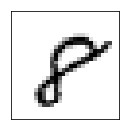

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]


In [9]:
plot_image(train_data[59999][0])
print(train_data[59999][1])

## Data filtering

Given `data = [(image, one_hot), ...]` create a `filtered_data = [(image, filtered_one_hot), ...]` of the same size. For each entry, `filtered_one_hot` only identifies the desired `digits` in the specified order. If less than the 10 digits are specified then an extra binary value is added at the end `filtered_one_hot` to capture the leftover digits.

In [10]:
def filter_data(data, digits):
  nb_digits = len(data[0][1])
  assert all(x >= 0 and x < nb_digits for x in digits) , 'Digits must be between 0 and 10.'
  assert all(x != y for x, y in zip(sorted(digits)[:-1], sorted(digits)[1:])), 'Digits must not repeat.'
  res = [(image, [one_hot[i] for i in digits]) for image, one_hot in data]
  if len(digits) == nb_digits:
    return res
  else:
    return [(image, one_hot + [1.0 - sum(one_hot)]) for image, one_hot in res]

## Utility TensorFlow code

In [11]:
# Run this to initialize or reset the session.
try:
  sess.close()
  tf.reset_default_graph()
except NameError:
  pass
sess = tf.InteractiveSession()

In [12]:
class Trainer:
  def __init__(self, trainable_variables, x_placeholder, y_placeholder, 
               permutation_placeholder, minibatch_size, train_step_node, 
               accuracy_node):
    global sess
    # Initialize all variables except trainable variables that are not
    # in trainable_variables.
    variables_to_init = (set(tf.all_variables()) - set(tf.trainable_variables())) \
                         | set(trainable_variables)
    sess.run(tf.initialize_variables(variables_to_init))
    self.base_index = 0
    self.accuracy = []
    self.x_placeholder = x_placeholder
    self.y_placeholder = y_placeholder
    self.permutation_placeholder = permutation_placeholder
    self.minibatch_size = minibatch_size
    self.train_step_node = train_step_node
    self.accuracy_node = accuracy_node

  def __gen_feed_dict(self, xs, ys, permutation, extra_feed_params):
    feed_dict = { 
      self.x_placeholder: xs, 
      self.y_placeholder: ys,
      self.permutation_placeholder: permutation
    }
    for key, value in extra_feed_params.items():
      feed_dict[key] = value
    return feed_dict
    
  def train(self, train_data, num_steps, accuracy_every_n_steps = 50, 
            extra_feed_params = {}):
    global sess
    assert len(train_data) % self.minibatch_size == 0, 'Minibatch size must be a divider of len(train_data)'
    for i in range(num_steps):
      index = (i + self.base_index)
      start_index = (index * self.minibatch_size) % len(train_data)
      end_index = start_index + self.minibatch_size
      batch_xs, batch_ys = zip(*train_data[start_index:end_index])
      permutation = range(len(batch_ys[0]))
      random.shuffle(permutation)
      feed_dict = self.__gen_feed_dict(batch_xs, batch_ys, permutation, 
                                       extra_feed_params)
      sess.run(self.train_step_node, feed_dict = feed_dict)
      if index % accuracy_every_n_steps == 0:
        curr_accuracy = float(sess.run(self.accuracy_node, feed_dict = feed_dict))
        print 'Iteration = %d, Training accuracy = %f' % (index, curr_accuracy)
        self.accuracy.append({ 'batch': index, 'accuracy': curr_accuracy })
    self.base_index += num_steps
    return self.accuracy

  def test_accuracy(self, test_data, extra_feed_params = {}):
    global sess
    result = 0.0
    num_batches = 100
    batch_len = len(test_data) / num_batches
    for i in range(num_batches):
      start_index = batch_len * i
      end_index = start_index + batch_len
      test_xs, test_ys = zip(*test_data[start_index:end_index])
      permutation = range(len(test_ys[0]))
      feed_dict = self.__gen_feed_dict(test_xs, test_ys, permutation,
                                       extra_feed_params)
      result += sess.run(self.accuracy_node, feed_dict = feed_dict)
    result = result / num_batches
    print 'Test accuracy = %f' % result

In [13]:
def weight_var(shape, name):
  return tf.get_variable(name, initializer = tf.truncated_normal(shape, stddev = 0.1))

def bias_var(shape, name):
  return tf.get_variable(name, initializer = tf.constant(0.1, shape = shape))

def conv_layer(input, filter, bias):
  return tf.nn.relu(tf.nn.conv2d(input, filter, [1,1,1,1], 'SAME') + bias)

def pool_layer(input):
  return tf.nn.max_pool(input, [1,2,2,1], [1,2,2,1], 'SAME')

def fully_connected_layer(input, weight, bias):
  return tf.nn.relu(tf.matmul(input, weight) + bias)

def fully_connected_sigmoid_layer(input, weight, bias):
  return tf.nn.sigmoid(tf.matmul(input, weight) + bias)

# Modular ConvNet

The idea is to build a modular MNIST classifier. Each module is an expert responsible for identifying a subset of the MNIST classes. For example an expert could be a binary classifier able to recognize a given digit.

In addition to the binary classification output, a module listens and talks onto a communication channel connecting all the modules. The goal is to allow modules to figure out an emerging _communication protocol_ that helps them inform one another and collectively converge on a better multi-class classification than each module taken independently.

## Why?

The hope is that such an architecture will allow us to train experts somewhat independently allowing:
- Each module to be significantly simpler than a full multi-class network ;
- Each module, once the protocol is determined, to be trainable in parallel ;
- The easy addition of new classes in the future at the cost of training new modules ;

## How?

Training occurs in two stages: the **protocol definition** stage and the **expert addition** stage.

During _protocol definition_ a collection of experts is trained on a small portion of the classes. As they are being trained a communication protocol emerges. After training, this protocol is frozen. What this means in practice is defined below.

During _expert addition_, new experts are trained on the remaining classes, but these experts have to abide by the existing protocol. This is done by including a fraction of the already-trained experts while training the new ones.

## Communication mechanism

Communication is a multi hop process. At each hop, a module reads _n_ signals from the channel (except on the first hop) and emits _m_ signals onto it (except on the last hop). The emitted signals are multiplexed onto the channel by an independent _multiplexing network_ which takes _k * m_ signals and generates the _n_ signals of the channel. The same multiplexing network is used at every hop. 

This multiplexing network is built in a modular fashion (see below) so that: 1) it can be trained during the _protocol definition_ while 2) allowing _k_ to be modified during the _expert addition_ phase or at inference time.

### Option 1: Cascading multiplexing

The _multiplexing network_ is made of _k_ copies of an identical _multiplexing unit (MU)_ which is a fully connected layer taking _m + n_ input signals and emitting _n_ signals. First the _k_ expert modules are ordered. The first _MU_ takes the _m_ signals emitted by the first module together with _n_ zero signals and emits _n_ signals that are fed into the second _MU_ which multiplexes them with the _n_ signals emitted by the second module.

The the order of the expert modules is randomized for each minibatch and for each hop to ensure we learn a general multiplexing unit.

**TODO:** Should there be a different _multiplexing unit_ for the first hop?

### Option 2: Hierarchical multiplexing

The _multiplexing network_ is made of _k/2_ copies of a _first level multiplexing unit (FLMU)_ and _lg(k/2)_ copies of an _internal multiplexing unit (IMU)_. The _FLMU_ is a fully connected layer taking _2n_ inputs and outputting _m_ signals. The _IMU_ takes _2m_ inputs and outputs _m_ signals.

Again the order of the expert modules is randomized for each minibatch and for each hop.

**TODO:** For the case where _k_ is odd we could have an alternate _FLMU_ taking _n+m_ inputs.

## Architecture

The communication channel has _n = 64_ signals. At each hop a module emits _m = 64_ signals. We use 1 hop. We use cascading multiplexing.

The architecture of each module is the following:
- `Input`: 28x28x1 MNIST images
- `Conv1`: 35 filters of 5x5x1 (ReLu)
- `Pool1`: Maxpool 2x2, output: 14x14x32
- `Conv2`: 64 filters of 5x5x32 (ReLu)
- `Pool2`: Maxpool 2x2, output: 7x7x64
- `FC`: Fully connected layer of 64 ReLu
- `COM`: Fully connected layer of 64 ReLu taking FC and emitting onto the communication channel
- `Output`: Single 128-way Sigmoid (64 inputs from FC, 64 from the incoming communication channel)

The `Conv*` and `Pool*` layers are shared between all expert module. The others are unique to each module.

The cascading _MU_ is a 64 ReLu fully connected layer with 128 inputs.

The Conv1, Conv2 layers are shared by every module. They're only trained during _protocol definition_.

# Main graph code

In [14]:
x = tf.placeholder(tf.float32, [None, 28, 28])

## Conv layers
These calls define the shared convolutional layers.

In [15]:
with tf.variable_scope("conv/l1"):
  conv_x = tf.reshape(x, [-1, 28, 28, 1])
  conv_l1_w = weight_var([5, 5, 1, 32], "w")
  conv_l1_b = bias_var([32], "b")
  conv_l1 = conv_layer(conv_x, conv_l1_w, conv_l1_b)
  conv_p1 = pool_layer(conv_l1)

In [16]:
with tf.variable_scope("conv/l2"):
  conv_l2_w = weight_var([5, 5, 32, 64], "w")
  conv_l2_b = bias_var([64], "b")
  conv_l2 = conv_layer(conv_p1, conv_l2_w, conv_l2_b)
  conv_p2 = pool_layer(conv_l2)

In [17]:
conv_out = tf.reshape(conv_p2, [-1, 7 * 7 * 64])

## Keras equivalent feature extractor 

In [90]:
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Convolution2D, MaxPooling2D, Lambda
from keras.layers import merge

In [50]:
def create_feature_extractor(input_shape, name):
    input_module = Input(shape=input_shape, 
                         name='Input_{}'.format(name))
    x = Convolution2D(35, 5, 5, 
                      border_mode='same',
                      name='conv1_{}'.format(name))(input_module)
    x = Activation('relu', name='act1_{}'.format(name))(x)
    x = MaxPooling2D(pool_size=(2, 2),
                     name='pool1_{}'.format(name))(x)
    x = Convolution2D(64, 5, 5, border_mode='same',
                      name='conv2_{}'.format(name))(x)
    x = Activation('relu',
                   name='act2_{}'.format(name))(x)
    out_features = MaxPooling2D(pool_size=(2, 2),
                                name='pool2_{}'.format(name))(x)
    return Model(input_module, out_features, name=name)
    

In [60]:
def create_module_specific_layers(input_shape, name):
    input_spec_module = Input(shape=input_shape)
    x = Flatten(name='Flatten_{}'.format(name))(input_spec_module)
    x = Dense(64, name='FC_{}'.format(name))(x)
    fc = Activation('relu', name='Relu_FC_{}'.format(name))(x)
    
    com = Dense(64, name='COM_{}'.format(name))(fc)
    com = Activation('relu', name='Relu2_{}'.format(name))(com)
    
    return (Model(input_spec_module, fc, name='Module_top_FC_{}'.format(name)),
           Model(input_spec_module, com, name='Module_top_COM_{}'.format(name)))
    

In [79]:
def create_module_bottom(input_shape_FC, input_shape_COM, name):
    input_bottom_FC = Input(shape=input_shape_FC, name='Input_FC_{}'.format(name))
    input_bottom_COM = Input(shape=input_shape_COM, name='Input_COM_{}'.format(name))
    
    concatenated_inputs = merge([input_bottom_FC, input_bottom_COM], mode='concat')
    x = Dense(128, name='Dense_{}'.format(name))(concatenated_inputs)
    out = Activation('sigmoid')(x)
    
    return Model([input_bottom_FC, input_bottom_COM], out, name=name)
    

In [62]:
def create_multiplexing_unit(input_shape_module, input_shape_channel, name):
    input_module = Input(shape=input_shape_module, name='Input_module_{}'.format(name))
    input_channel = Input(shape=input_shape_channel, name='Input_chanel_{}'.format(name))
    
    concatenated_inputs = merge([input_module, input_channel])
    
    x = Dense(64, name='Dense_{}'.format(name))(concatenated_inputs)
    out = Activation('relu')(x)
    
    return Model([input_module, input_channel], out, name=name)

In [91]:
def shuffle(modules_index):
    modules, index = modules_index
    return K.gather(modules, indexing)


def output_of_lambda(input_shape):
    return (input_shape[0], 1, input_shape[2])


def create_shuffled_outputs_model(input_shape, modules):
    input_shuffling = Input(input_shape=input_shape)
    size_shuffle = len(modules)
    input_index = Input(input_shape=(size_shuffle, ))
    outputs_modules = []
    for module in modules:
        outputs_modules.append(module(input_shuffling))
    merged_outputs = merge(outputs_modules, mode='concat')
    outputs = [merged_outputs[:, :, i] for i in range(size_shuffle)]
#     shuffled_outputs = Lambda(shuffle, output_shape=())([merged_outputs, input_index])
    return Model([input_shuffling, input_index], outputs, name='Shuffled_outputs')
        
    

## Test Models 

### Feature extraction 

In [51]:
feature_extractor = create_feature_extractor((28, 28, 1), 'Features')

In [57]:
feature_extractor.predict(X_train[:32, :, :, None]).shape

(32, 7, 7, 64)

In [56]:
model_input = Input(shape=(28, 28, 1))
features = feature_extractor(model_input)

### FC and COM layers

In [64]:
FC, COM = create_module_specific_layers(input_shape=(7, 7, 64), name='Specific_1')

In [65]:
fc_output = FC(features)
com_output = COM(features)

In [68]:
fc_model = Model(model_input, fc_output, name='FC')
com_model = Model(model_input, com_output, name='COM')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
Features (Model)                 (None, 7, 7, 64)      56974       input_1[0][0]                    
____________________________________________________________________________________________________
Module_top_FC_Specific_1 (Model) (None, 64)            200768      Features[1][0]                   
Total params: 257,742
Trainable params: 257,742
Non-trainable params: 0
____________________________________________________________________________________________________
Fontconfig warning: ignoring C.UTF-8: not a valid language tag



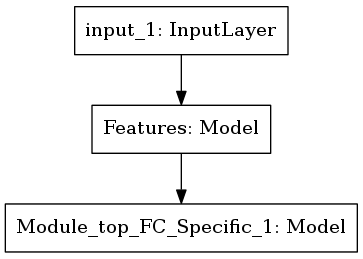

In [74]:
from IPython.display import Image
from keras.utils.visualize_util import model_to_dot

Image(model_to_dot(fc_model).create(prog='dot', format='png'))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
Features (Model)                 (None, 7, 7, 64)      56974       input_1[0][0]                    
____________________________________________________________________________________________________
Module_top_COM_Specific_1 (Model (None, 64)            204928      Features[1][0]                   
Total params: 261,902
Trainable params: 261,902
Non-trainable params: 0
____________________________________________________________________________________________________
Fontconfig warning: ignoring C.UTF-8: not a valid language tag



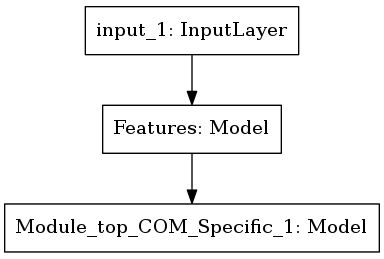

In [75]:
Image(model_to_dot(com_model).create(prog='dot', format='png'))

In [77]:
print(fc_model.predict(X_train[:32, :, :, None]).shape)
print(com_model.predict(X_train[:32, :, :, None]).shape)

(32, 64)
(32, 64)


### Output layer 

In [80]:
bottom_layers = create_module_bottom(input_shape_FC=(64, ), input_shape_COM=(64, ), name='Bottom_1')

In [82]:
output_bottom = bottom_layers([fc_output, com_output])
model_bottom = Model(model_input, output_bottom, name='Bottom_1')

In [84]:
model_bottom.predict(X_train[:32, :, :, None]).shape

(32, 128)

### MUnit 

In [85]:
model_multiplex = create_multiplexing_unit(input_shape_module=(64, ), input_shape_channel=(64, ), name='MUnit')

In [86]:
output_mu_unit = model_multiplex([fc_output, com_output])

In [88]:
model_munit = Model(model_input, output_mu_unit, name='Mu_Unit')

In [89]:
model_munit.predict(X_train[:32, :, :, None]).shape

(32, 64)

### Cascading Multiplexing 

In [ ]:
modules = [Model(model_input, output_bottom, name='Bottom_1')]
create_shuffled_outputs_model

## Module-specific layers

These functions create the layers specific to a given expert module.

In [18]:
# Important, set tf.variable_scope before calling these functions.
# In this scope, set |reuse = True| to load previously created
# variables.

# Creates the top part of the module: the FC and COM layers.
# Returns the output of these layers in that order.
def create_module_top():
  global conv_out
  with tf.variable_scope("fc"):
    fc_w = weight_var([7 * 7 * 64, 64], "w")
    fc_b = bias_var([64], "b")
    fc = fully_connected_layer(conv_out, fc_w, fc_b)
  with tf.variable_scope("com"):
    com_w = weight_var([64, 64], "w")
    com_b = bias_var([64], "b")
    com = fully_connected_layer(fc, com_w, com_b)
  return fc, com

# Creates the bottom part of the module given the FC of this module and channel.
# Return the output.
def create_module_bottom(fc_module, channel):
  with tf.variable_scope("out"):
    concat = tf.concat(1, [fc_module, channel])
    output_w = weight_var([128, 1], "w")
    output_b = weight_var([1], "b")
    output = fully_connected_sigmoid_layer(concat, output_w, output_b)
  return output

## Communication channel
These function creates a single multiplexing unit. Every multiplexing unit share the same weights.

In [19]:
with tf.variable_scope("mu"):
  mu_w = weight_var([128, 64], "w")
  mu_b = bias_var([64], "b")

In [20]:
def create_multiplexing_initial_unit(input_from_module):
    global mu_w, mu_b
    # Keeping only the first 64 weights is equivalent to considering that the
    # initial channel is filled with zeros.
    output = fully_connected_layer(input_from_module, 
                                   tf.slice(mu_w, [0,0], [64,64]), mu_b)
    return output

def create_multiplexing_unit(input_from_module, input_from_channel):
    global mu_w, mu_b
    concat = tf.concat(1, [input_from_module, input_from_channel])
    output = fully_connected_layer(concat, mu_w, mu_b)
    return output

## Connected modules

Function for creating connected modules. Specify two sets of digits: the ones for which we should reuse existing modules, and the ones for which we should create existing modules. If you do not specify the full list of 10 digits then you must specify an other_class_name representing a module (which will be newly created) to classify the missing digits.

The result is a tuple `(output, permutation)`. Where `output` is a tensor of shape `(?, n)` with `n` being the number of classes that can be distinguished. And where `permutation` is a placeholder for a tensor of shape `(n)` that should be populated with shuffled elements of `range(n)`.

In [21]:
def create_modules(digits_to_reuse, digits_to_create, other_class_name = None):
  assert (len(digits_to_reuse) + len(digits_to_create) == 10) != \
         (other_class_name != None)
  names_and_reuses = zip(
    ["digit%d" % i for i in digits_to_reuse + digits_to_create],
    [True] * len(digits_to_reuse) + [False] * len(digits_to_create))
  if other_class_name != None:
    names_and_reuses.append((other_class_name, False))

  # Reuse or create the top of the modules.
  modules_fc_and_com = []
  for name,reuse in names_and_reuses:
    with tf.variable_scope(name, reuse = reuse):
      modules_fc_and_com.append(create_module_top())
  
  # Take the communication output of each channel and shuffle them to randomize
  # the order in which they are added to the communication channel.
  permutation = tf.placeholder(tf.int32, [len(modules_fc_and_com)])
  packed_com = tf.pack([com for fc,com in modules_fc_and_com])
  shuffled_com = tf.unpack(tf.gather(packed_com, permutation))
  
  # Multiplex the shuffled communication outputs one after the other onto the
  # communication channel.
  channel = create_multiplexing_initial_unit(shuffled_com[0])
  for com in shuffled_com[1:]:
    channel = create_multiplexing_unit(com, channel)
   
  # Reuse or create the bottom of the modules.
  module_outputs = []
  for (fc,com),(name,reuse) in zip(modules_fc_and_com, names_and_reuses):
    with tf.variable_scope(name, reuse = reuse):
      module_outputs.append(create_module_bottom(fc, channel))

  # Softmax the output of each module.
  output = tf.concat(1, module_outputs)
  return tf.nn.softmax(output), permutation

## Filtered datasets

Indicate which digits are recognized by expert modules trained during the **protocol definition** stage and which are left to expert modules trained during the **expert addition** stage. Create datasets appropriate for each stage.

In [22]:
pd_digits = [0,1,  3,4,5,6,  8  ]
ea_digits = [    2,        7,  9]

In [23]:
train_data[0][1]

[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]

In [24]:
pd_train_data = filter_data(train_data, pd_digits)
pd_test_data = filter_data(test_data, pd_digits)
ea_train_data = filter_data(train_data, pd_digits + ea_digits)
ea_test_data = filter_data(test_data, pd_digits + ea_digits)

## Protocol definition stage

We create the connected modules for the protocol definition stage. We create modules for digits 0,1,3,4,6,7,8 and train them together with the multiplexing unit.

In [25]:
# Hyper parameters for protocol definition
pd_minibatch_size = 100
pd_num_minibatches = 2000
pd_learning_rate = 1e-5

In [26]:
pd_output, pd_permutation = create_modules([], pd_digits, 'other_class')

In [27]:
pd_y_ = tf.placeholder(tf.float32, [None, 8])

pd_cross_entropy = tf.reduce_mean(
    -tf.reduce_sum(pd_y_ * tf.log(pd_output), reduction_indices=[1]))

pd_correct_prediction = tf.equal(tf.argmax(pd_output,1), tf.argmax(pd_y_,1))
pd_accuracy = tf.reduce_mean(tf.cast(pd_correct_prediction, tf.float32))

pd_train_step = tf.train.AdamOptimizer(pd_learning_rate).minimize(pd_cross_entropy)

/opt/conda/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:91: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [28]:
pd_trainer = Trainer(tf.trainable_variables(), x, pd_y_, pd_permutation, 
                     pd_minibatch_size, pd_train_step, pd_accuracy)

Instructions for updating:
Please use tf.global_variables instead.
Instructions for updating:
Use `tf.variables_initializer` instead.


**Full training**

In [29]:
pd_graph = pd_trainer.train(pd_train_data, pd_num_minibatches)

Iteration = 0, Training accuracy = 0.110000
Iteration = 50, Training accuracy = 0.120000
Iteration = 100, Training accuracy = 0.100000
Iteration = 150, Training accuracy = 0.070000
Iteration = 200, Training accuracy = 0.070000
Iteration = 250, Training accuracy = 0.090000
Iteration = 300, Training accuracy = 0.110000
Iteration = 350, Training accuracy = 0.110000
Iteration = 400, Training accuracy = 0.130000
Iteration = 450, Training accuracy = 0.070000
Iteration = 500, Training accuracy = 0.120000
Iteration = 550, Training accuracy = 0.110000
Iteration = 600, Training accuracy = 0.180000
Iteration = 650, Training accuracy = 0.220000
Iteration = 700, Training accuracy = 0.190000
Iteration = 750, Training accuracy = 0.190000
Iteration = 800, Training accuracy = 0.200000
Iteration = 850, Training accuracy = 0.200000
Iteration = 900, Training accuracy = 0.160000
Iteration = 950, Training accuracy = 0.210000
Iteration = 1000, Training accuracy = 0.240000
Iteration = 1050, Training accuracy 

**Manual training**

In [30]:
# Uncomment and run manually to try just a couple more training steps.
#pd_graph = pd_trainer.train(pd_train_data, 100, accuracy_every_n_steps = 10)

**Results visualisation**

In [31]:
%%chart line --fields batch,accuracy --data pd_graph

ERROR:root:Cell magic `%%chart` not found.


In [32]:
pd_trainer.test_accuracy(pd_test_data)

Test accuracy = 0.203700


## Expert addition

In [33]:
# Hyper parameters for protocol definition
ea_minibatch_size = 100
ea_num_minibatches = 2000
ea_learning_rate = 1e-5

In [34]:
ea_output, ea_permutation = create_modules(pd_digits, ea_digits)

In [35]:
# Freeze all variables, except trainable ones.
ea_trainable_variables = []
for digit in ea_digits:
  ea_trainable_variables += tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                              'digit%d' % digit)

In [36]:
ea_y_ = tf.placeholder(tf.float32, [None, 10])

ea_cross_entropy = tf.reduce_mean(
    -tf.reduce_sum(ea_y_ * tf.log(ea_output), reduction_indices=[1]))

ea_correct_prediction = tf.equal(tf.argmax(ea_output,1), tf.argmax(ea_y_,1))
ea_accuracy = tf.reduce_mean(tf.cast(ea_correct_prediction, tf.float32))

ea_train_step = tf.train.AdamOptimizer(ea_learning_rate).minimize(
    ea_cross_entropy, var_list = ea_trainable_variables)

In [37]:
ea_trainer = Trainer(ea_trainable_variables, x, ea_y_, ea_permutation, 
                     ea_minibatch_size, ea_train_step, ea_accuracy)

Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


**Full training**

In [38]:
ea_graph = ea_trainer.train(ea_train_data, ea_num_minibatches)

Iteration = 0, Training accuracy = 0.250000
Iteration = 50, Training accuracy = 0.220000
Iteration = 100, Training accuracy = 0.210000
Iteration = 150, Training accuracy = 0.200000
Iteration = 200, Training accuracy = 0.200000
Iteration = 250, Training accuracy = 0.210000
Iteration = 300, Training accuracy = 0.180000
Iteration = 350, Training accuracy = 0.210000
Iteration = 400, Training accuracy = 0.250000
Iteration = 450, Training accuracy = 0.200000
Iteration = 500, Training accuracy = 0.200000
Iteration = 550, Training accuracy = 0.190000
Iteration = 600, Training accuracy = 0.270000
Iteration = 650, Training accuracy = 0.220000
Iteration = 700, Training accuracy = 0.210000
Iteration = 750, Training accuracy = 0.200000
Iteration = 800, Training accuracy = 0.200000
Iteration = 850, Training accuracy = 0.210000
Iteration = 900, Training accuracy = 0.190000
Iteration = 950, Training accuracy = 0.210000
Iteration = 1000, Training accuracy = 0.250000
Iteration = 1050, Training accuracy 

**Manual training**

In [39]:
# Uncomment and run manually to try just a couple more training steps.
#ea_graph = ea_trainer.train(ea_train_data, 100, accuracy_every_n_steps = 10)

**Results visualisation**

In [40]:
%%chart line --fields batch,accuracy --data ea_graph

ERROR:root:Cell magic `%%chart` not found.


In [41]:
ea_trainer.test_accuracy(ea_test_data)

Test accuracy = 0.204900
